# BeSafeBox - fall detection model creation

BeSafeBox model is based on manually crafted set of features from an acceleration data, which are selected by their overall
performance in prediction of fall / collapse events. These features are used to train traditional machine-learning
models like RandomForest or SVM. These models are then used in the Android app.

Used libraries:

* [NumPy](https://numpy.org/doc/stable/contents.html) - 1.20.1
* [Pandas](https://pandas.pydata.org/docs/index.html) - 1.2.3
* [Matplotlib](https://matplotlib.org/stable/index.html) - 3.3.3
* [Seaborn](https://seaborn.pydata.org/#) - 0.11.1
* [Scikit-learn](https://scikit-learn.org/stable/index.html) - 0.24.1
* [LOFO - importance](https://github.com/aerdem4/lofo-importance) - 0.2.6 - leave one out feature importance
* [tqdm](https://github.com/tqdm/tqdm) - 4.59.0 -  progress bar
* [sklearn-porter](https://github.com/nok/sklearn-porter) - 0.7.4 -
Transpile trained scikit-learn estimators to C, Java, JavaScript and others.
* [NumBa](https://numba.pydata.org/) - 0.53.0 -
JIT compiler that translates a subset of Python and NumPy code into fast machine code
* [bayes_opt](https://github.com/fmfn/BayesianOptimization) - 1.2.0 - Bayesian optimization algorithm

In [10]:
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning) # bug in iPython

from EventOfInterest import EventOfInterest
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import traceback
import pickle

from CustomPaths import get_paths_real_life, get_paths_control_environment
from DataCarrier import DataCarrier, SensorData
from EventChecker import check_data_integrity_fall_detection, calculate_time_magnitude, get_event_of_interest
from Parameters import calculate_acg_parameters, calculate_acg_parameters_data_carrier
from Consts import string_activity_to_number, Consts, number_to_string_activity_binary, number_to_string_activity_multiple
from IQRCleaning import iqr_rule_outliers

from lofo import LOFOImportance, Dataset, plot_importance
from tqdm.autonotebook import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import f1_score, recall_score, classification_report

sns.set_context("paper")
sns.set(font="Times New Roman", font_scale=1.25)  # font_scale=1.25
sns.set_style("darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data description

The data were recorded with a custom app, SensorBox, which have been created because of the BeSafeBox to provide a native way
of a data aggregation for smartphone sensor data. The app is available for free at
[Google Play](https://play.google.com/store/apps/details?id=motionapps.sensorbox).

3260 measurements were recorded in total with 23 participants. 3 main activities were picked to simulate, which are the
most common in daily life: sitting, walking, laying down. These activities have familiar acceleration signal with the fall event.

**Distribution of events:**

* 667 walks
* 840 falls
* 551 lay downs
* 1071 sits

Every measurement has 10 seconds in length and 2 different smartphones were used for the measurements:
* **Huawei P9** - lower sampling rate, range ±8g
* **Sony Xperia Z5 Compact** - higher sampling rate, range ±4g

\(The sampling rate of the sensors changes during different states of the smartphones - none specific frequency can be
justified, only an average one)

The placement of the phones changed all the time. The phones were placed usually in a pocket
of  jeans, shirt, trousers or jacket.

As we can see below on charts, the signals are similar, but there are some major differences between them.

* **sit** - hard surface - the small / significant dip before impact, with one single peak
* **sit** - soft surface - the small / significant dip before impact, with the small amplitude and the gradual attenuation
* **lay** - on a bed - small / significant dip, with amplitude and gradual attenuation - similar to sit on soft surface
* **walk with a sudden stop / other action** - periodic changes in the acceleration with an ending peak of higher amplitude
* **fall** - none / significant dip before impact. Multiple peaks can occur in short period of time as
different parts of body are falling on the ground.

The dip is created due to the free fall of the person, where the gravitational pull is partially transformed to the velocity
of the person.

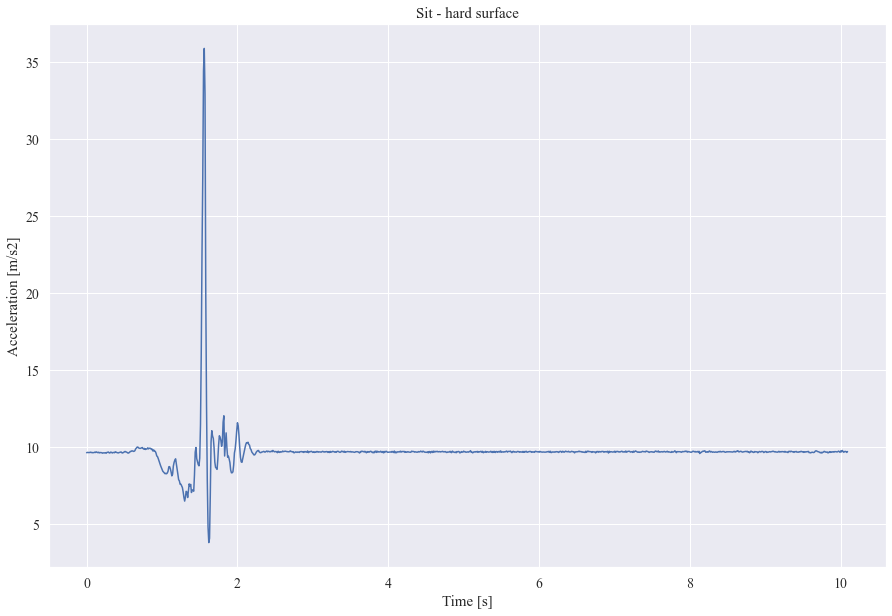

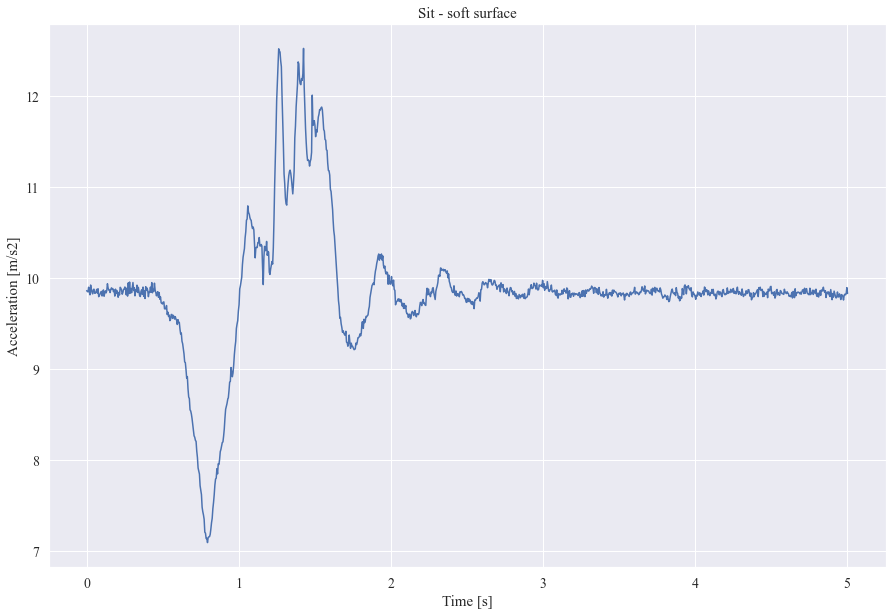

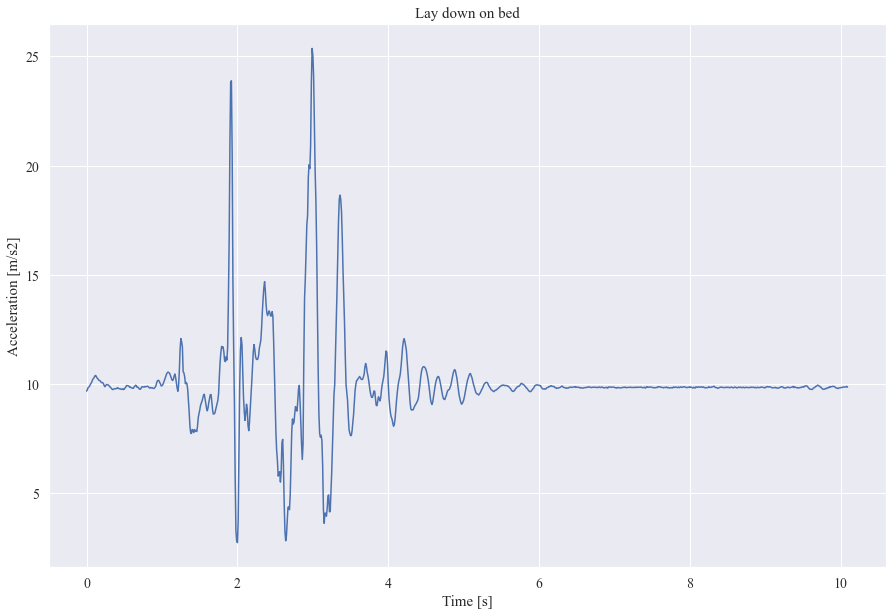

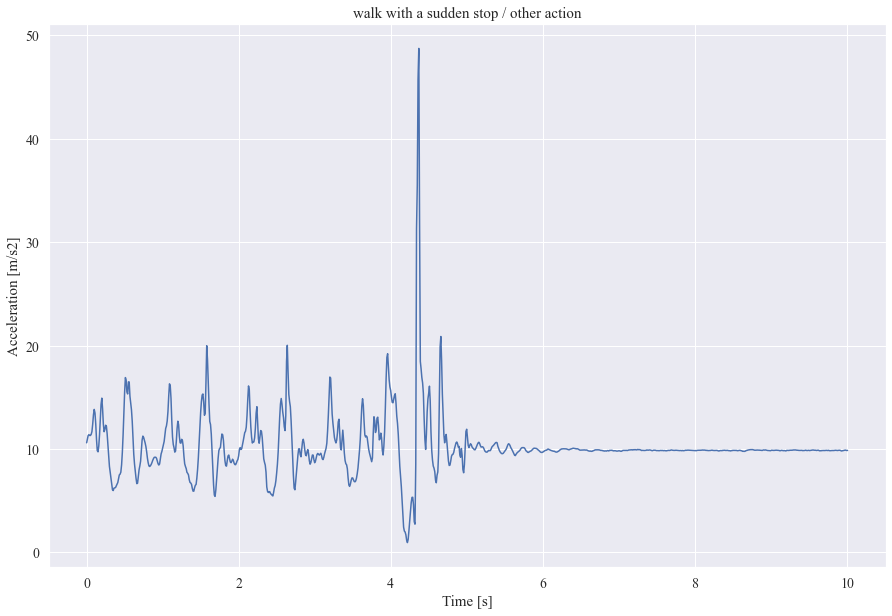

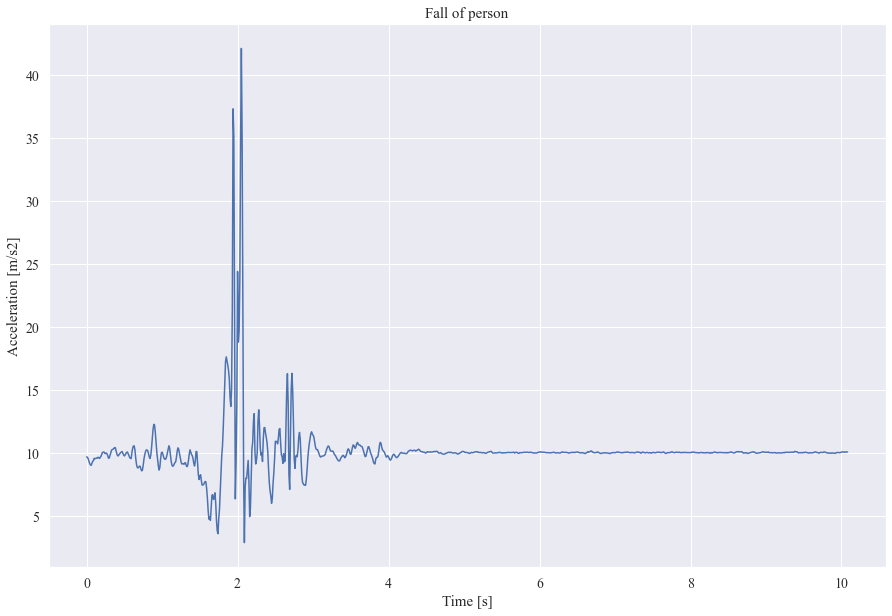

In [32]:
%matplotlib inline

from CustomPaths import sample_data, sample_data_titles

for measurement_path, title in zip(sample_data, sample_data_titles):
    measurement_item: DataCarrier = DataCarrier(measurement_path)
    calculate_time_magnitude(measurement_item.sensor_data[Consts.ACG])
    plt.figure(figsize=(15, 10))
    plt.plot(measurement_item.sensor_data[Consts.ACG].modified[Consts.TIME_SECONDS],
             measurement_item.sensor_data[Consts.ACG].modified[Consts.MAGNITUDE])
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Acceleration [m/s2]")

del measurement_path, title

# Reading data

### Main object
Reading the data is taken care of by the **DataCarrier** object, which posses methods to process
sensor data, GPS and extra data files, from which are extracted all necessary data.
DataCarrier, as name suggests, carries all the data in form of the numpy arrays.

### Data validation
Prior to any parameter calculation, validation of the acceleration data takes place. There cannot be any long
delay between samples. Delay must be less than **0.2s**, and the measurement must contain a peak with magnitude of at
least **1.6g**.

### Picking region of interest
The parameters are calculated from a specific period of signal centered at the highest peak with a **max length of 1s**.
Firstly, algorithm tries to find dip created by free fall, which is bellow **0.9g**. The maximum length from beginning
of the event to the max peak can be **0.3s**. From the peak to the end of the event, the length can be **0.7s**. The max length
is also bordered with a sample with a minimum value of **1.5g**. Different smartphones provide different number of samples
in a similar time window, so the algorithm has to cope with different lengths of created windows.

### Calculated parameters

There are calculated 19 parameters for the acceleration, which are mainly of a statistical character. The calculation
and resources can be found in **Parameters.py**, which are calculated after a validation with the function
**calculate_acg_parameters_data_carrier**.

* average
* standard deviation
* variance / activity
* mobility, complexity - Hjorth coefficients
* TKEO
* average output
* entropy approximation
* waveform length
* Crest factor
* change in angle
* change in angle with cosine
* angle deviation
* free fall index
* min-max difference
* 3g ratio
* kurtosis
* skewness
* 1g cross rate


In [4]:
# paths to every single measurement - 3260 measurements -> 3260 DataCarriers
# measurements are separated to folders by specific person

parameters = []
Y = []

for i, measurement_folder in enumerate(tqdm(get_paths_control_environment(), desc="Folders of measurements")):
    data_carrier: DataCarrier = DataCarrier(measurement_folder)
    validity: bool = check_data_integrity_fall_detection(data_carrier, pick_event=True)
    # checks validity of measurement
    if validity:
        parameters_temp: np.ndarray = calculate_acg_parameters_data_carrier(data_carrier)
        # checks if no error occurred during calculation
        if parameters_temp is not None:
            int_activity_type: int = string_activity_to_number(data_carrier.activity_type)
            # checks if measured activity is valid
            if int_activity_type is not None:
                parameters.append(parameters_temp)
                Y.append(int_activity_type)
                continue

parameters = np.vstack(parameters)
Y = np.array(Y)

del measurement_folder

Folders of measurements:   0%|          | 0/3260 [00:00<?, ?it/s]

In [5]:
# save data
df = pd.DataFrame(parameters, columns=Consts.parameters_names)
df_y = df.copy()
df_y["Y"] = Y
df_y.to_csv(path_or_buf="temp_data/parameters.csv", sep=";", index=False)
del df_y

# Cleaning the data

From the original data, 4 % measurements were expelled, mainly due to the low magnitude in the measurements, which would
not be enough to trigger an indication of the fall-event. After getting all the parameters, we can clean the data with
an IQR rule. The fences are calculated based on inter-quartile rule. With cleaned data, we can normalise them with min-max
method to range 0-1 to adjust range for machine-learning models.

The IQR rule is more benevolent for outliers, because some of them stays in the visualisation. It is because, if neighbours
are similar to outlier, it means that the outlier is not outlier. If we took them down, we would decrease accuracy
even by 4 %.

For the visualisation, we can melt the table to the variables, values, and a class, which can be then passed to a boxplot. From
the visualisation, we can predict that changes in angles of acceleration are crucial for the fall classification, but
more parameters are required in order to distinguish them among the lays and sits e.g. 1g crosses, average, standard
deviation, 3g ratio and others.

### Feature importance estimation

For a feature importance estimation, we use the leave-one-out technique, where we remove one iteratively and check a
performance of the model. For that we use simple library [LOFO](https://github.com/aerdem4/lofo-importance).

In [2]:
df = pd.read_csv("temp_data/parameters.csv", sep=";")
Y = df["Y"].to_numpy()

Y_one_hot = (Y==3)*1 # falls to mark as 1
print("{} / {:.2f}% measurements have not been used for parameters calculation".format(3260 - df.shape[0], ((3260 - df.shape[0])/3260)*100))

# cleaning the data
df_cleaned, fences = iqr_rule_outliers(df, Y, apply_iqr=False)

# normalisation
minimums = df_cleaned.min()
maximums = df_cleaned.max()
df_cleaned: pd.DataFrame = (df_cleaned-df_cleaned.min())/(df_cleaned.max()-df_cleaned.min())

# storing data about borders for the app
with open("temp_data/min_max.pickle", "wb") as file:
    pickle.dump(obj=(df_cleaned.min(), df_cleaned.max()), file=file)

df_cleaned.to_csv(path_or_buf="temp_data/parameters_cleaned.csv", sep=";", index=False)

133 / 4.08% measurements have not been used for parameters calculation


Processed features:   0%|          | 0/20 [00:00<?, ?it/s]

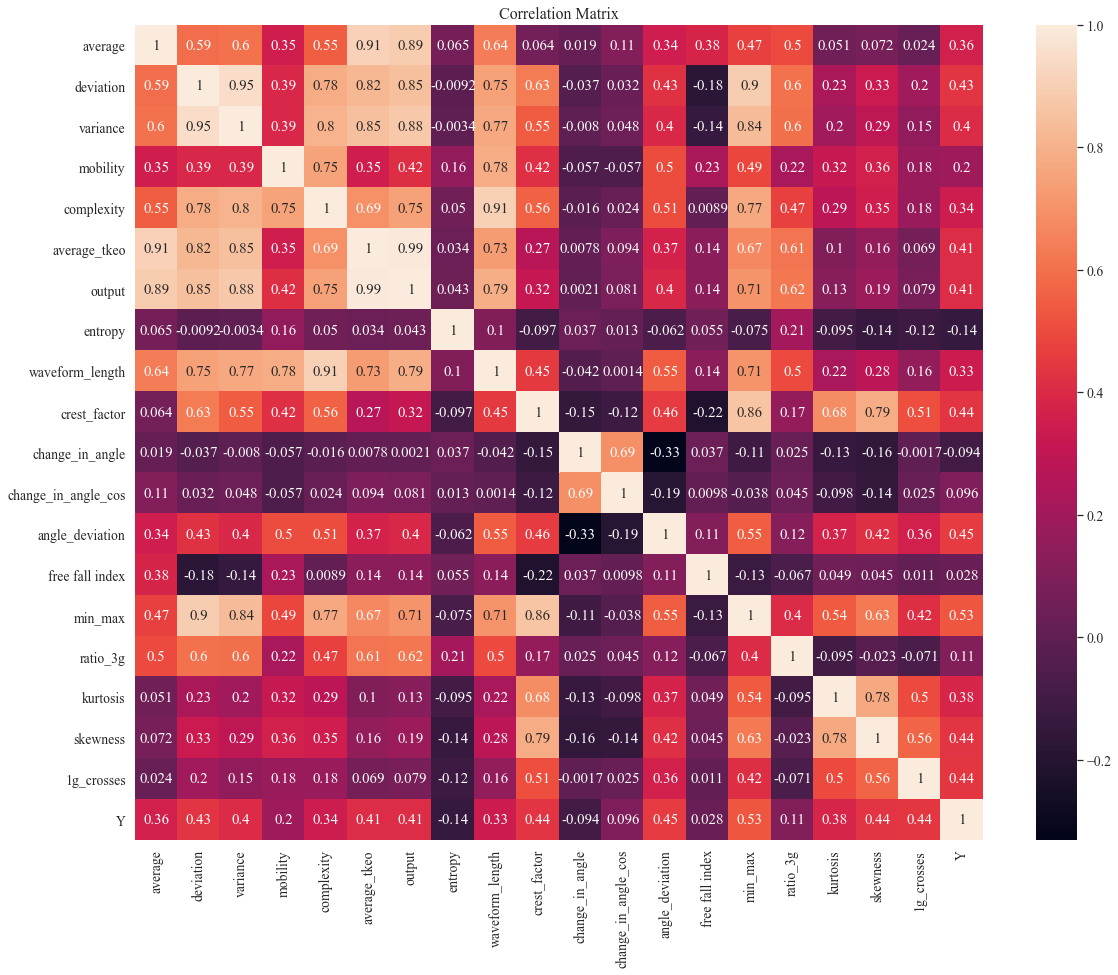

In [3]:
# correlation matrix
%matplotlib inline
sns.set(font="Times New Roman", font_scale=1.25)
f = plt.figure(figsize=(19, 15))
ax = sns.heatmap(df_cleaned.corr(), annot=True)
ax.set_title('Correlation Matrix', fontsize=16)

del f, ax

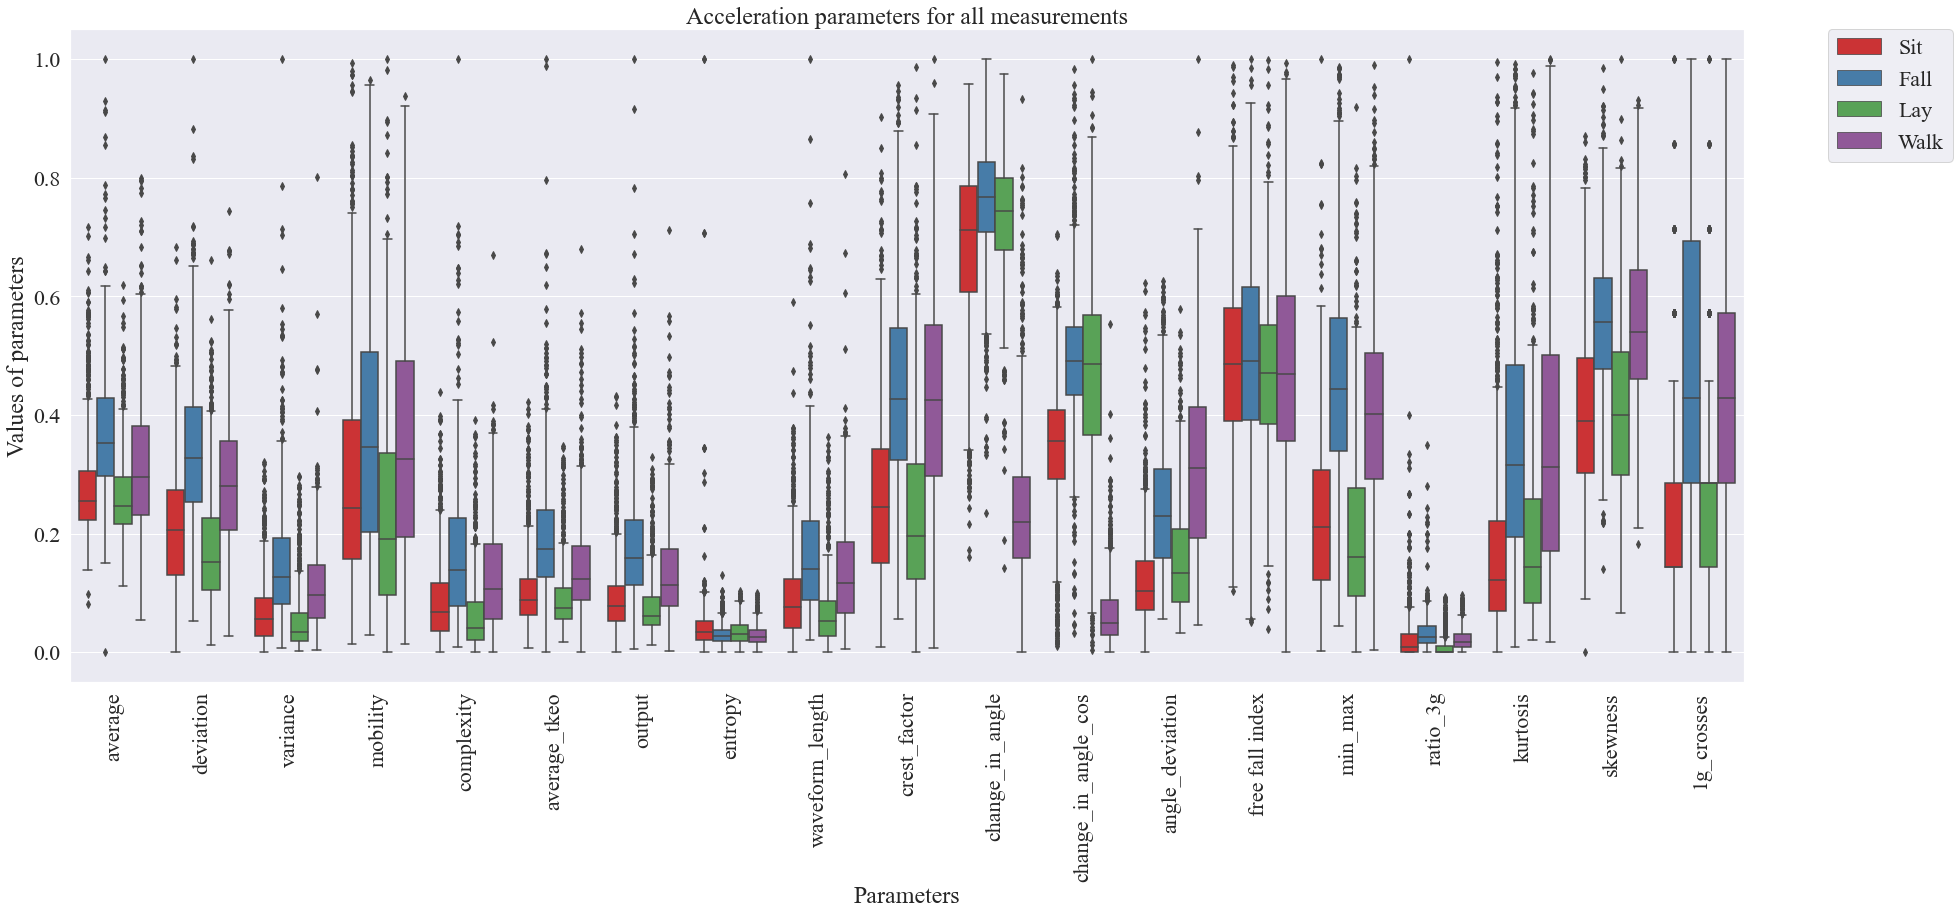

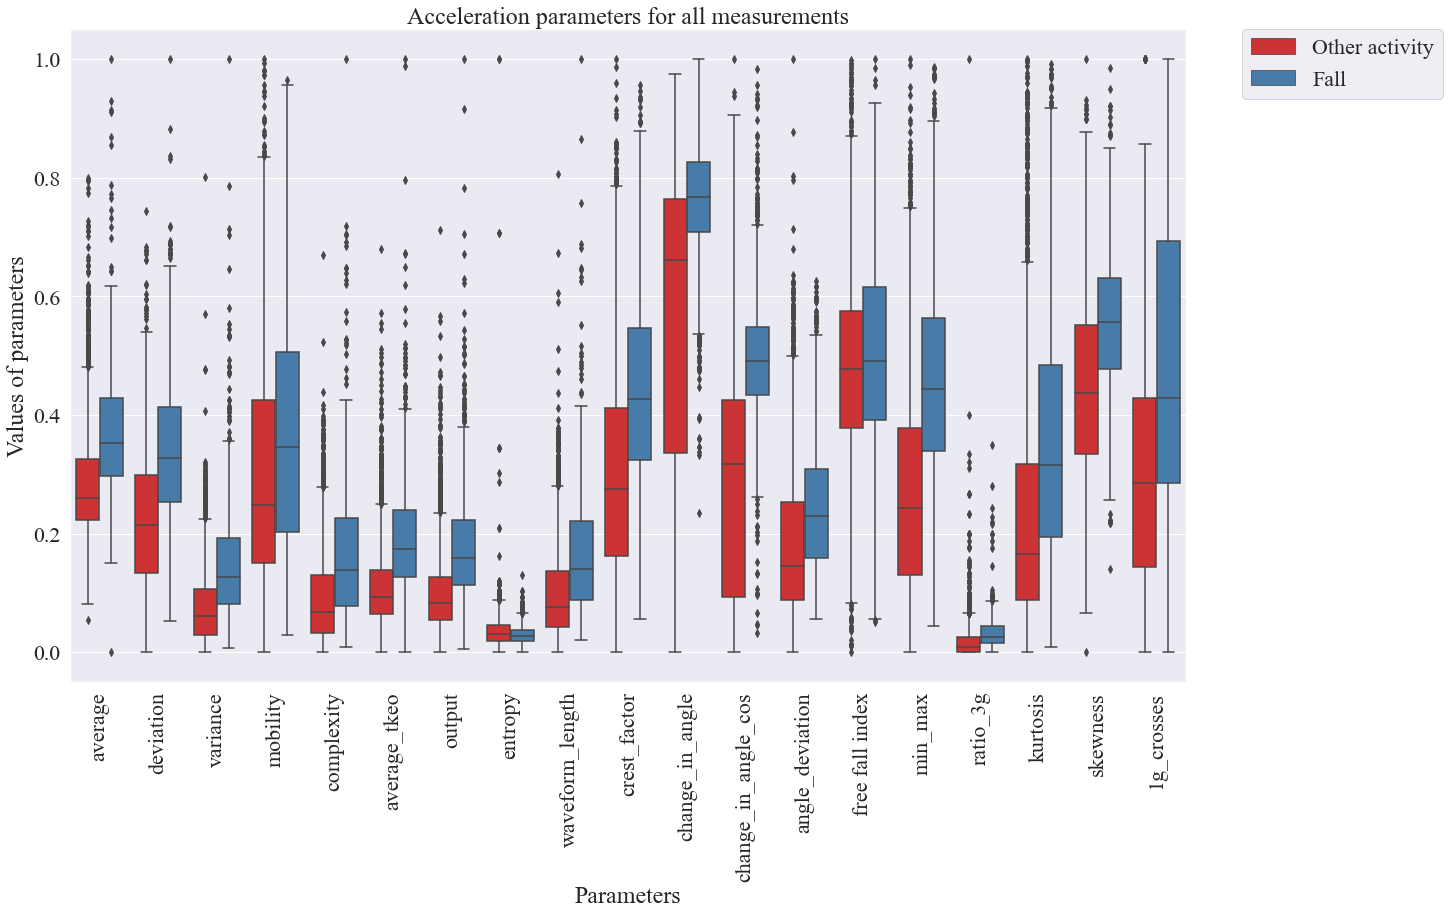

In [4]:
%matplotlib inline
# simple function to melt dataframe and create boxplot chart of features
def plot_boxplot(df_to_plot: pd.DataFrame, size=(20, 12)):
    df_to_boxplot: pd.DataFrame = df_to_plot.melt(id_vars="Y")

    # horizontal chart would be preferred, but seaborn does not support horizontal boxplots without numeric y axis
    plt.figure(figsize=size)
    chart = sns.boxplot(x="variable", y="value", hue="Y", data=df_to_boxplot, palette="Set1")
    chart.set_xlabel("Parameters")
    chart.set_ylabel("Values of parameters")
    chart.set_title("Acceleration parameters for all measurements")
    chart.set_xticklabels(labels=Consts.parameters_names, rotation=90)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# creation of charts

sns.set(font="Times New Roman", font_scale=2)
df_cleaned["Y"] = list(map(number_to_string_activity_multiple, Y))
plot_boxplot(df_cleaned, size=(30, 12))

df_cleaned["Y"] = list(map(number_to_string_activity_binary, Y_one_hot))
plot_boxplot(df_cleaned)
sns.set(font="Times New Roman", font_scale=1.25)

In [6]:
df_cleaned["Y"] = Y_one_hot
# to save ratio of falls and other activities, the StratifiedKFold is picked
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
dataset = Dataset(df=df_cleaned, target="Y", features=Consts.parameters_names)

# applicaiton of LOFO
lofo_imp = LOFOImportance(dataset, cv=k_fold, scoring="roc_auc")
importance_df = lofo_imp.get_importance()

del k_fold, lofo_imp

  0%|          | 0/19 [00:00<?, ?it/s]

### Feature importance results

As we can see at the chart below, our prediction of the changes in an angle was correct. The change in the angle with
cosine is the most important feature. At second place is also the change in a angle, which is calculated only from the
main event. These features are correlated, however LOFO does not know to distinguish that, so it will be omitted.
Another significant features are 1g crossings, free fall index, kurtosis, and average. There are min-max,
mobility and other features, but they are highly correlated with an already included feature, or they have wide range of
importance.


Picked features: change in angle with cosine, 1g crossings, average, kurtosis, free fall index

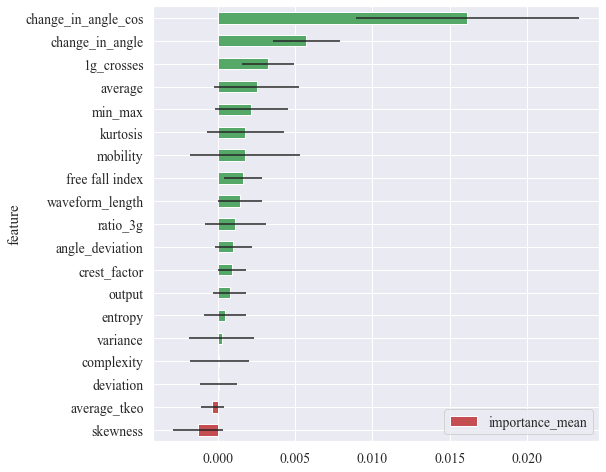

In [7]:
%matplotlib inline
plot_importance(importance_df)

In [8]:
top_features = importance_df.feature.values[[0,2,3,5,7]]
df_picked_features = df_cleaned[top_features].copy()

In [11]:
# split of the data to leave some data for validation
# 80 % will be used for data stratified k-fold and 20 % for validation
df_picked_features_copy = df_picked_features.copy()
df_picked_features_copy["Y"] = Y_one_hot

train_set, val_set = np.split(df_picked_features_copy.sample(frac=1, random_state=123), [int(.8*len(df))])
train_X = train_set[top_features].values
train_y = train_set["Y"].values

val_X = val_set[top_features].values
val_y = val_set["Y"].values

del df_picked_features_copy

# Model training

Bayesian optimization was picked to optimize our model, because of the efficient procedure of the search for hyper-parameters.

### Random forest

Random forest generates multiple simpler classification trees to reduce a variance of the final model, but a lot of trees
can result also in an over-fitting . Good performance is easy to obtain, because of the nature of the model.
Main disadvantage is bigger memory requirement, what is essential to avoid for the phone app.

As we can see, the optimal number of the trees is around 15 at the chart below, where we obtain maximum average F1 score
for 5 split Kfold.

The training function is modified to return only one value for simpler input for optimization functions. The input is in
form of the kwargs, so the optimization function or us can pass any parameters to optimise.

For further optimization we picked number of trees, max depth, number of samples for split and minimal samples leaf.

### SVM

We also tried SVM model, which is much more lightweight than RandomForest. However, the SVM can
under-perform at our situation, because of high number of noisy data with a lot of data points. We will use rbf kernel
to minimize impact of atypical distribution. Parameter C \(trade-off to allow some wrong classifications) and Gamma
\( how many neighbours will be taken into account) will be optimized.

Creating forests:   0%|          | 0/59 [00:00<?, ?it/s]

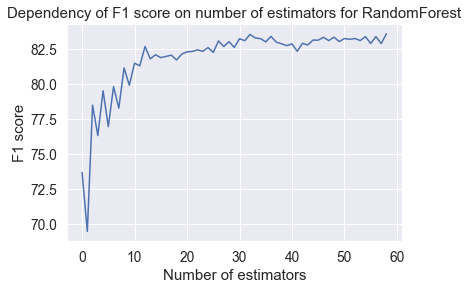

In [12]:
# function for optimisation
def train_model(**kwargs):
    fold_object = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
    kwargs["random_state"] = 123

    validation_results = []
    validation_f1_results = []
    validation_recall_results = []
    kwargs["class_weight"] = "balanced"

    # to improve range capabilities of the BayesianOptimization
    if "gamma" in kwargs:
        kwargs["gamma"] = 10 ** -kwargs["gamma"]

    # BayesianOptimization does not know to work with discreet values
    if "n_estimators" in kwargs:
        kwargs["n_estimators"] = int(kwargs["n_estimators"] )

    if 'min_samples_leaf' in kwargs:
        kwargs['min_samples_leaf'] = int(kwargs['min_samples_leaf'] )

    if 'min_samples_split' in kwargs:
        kwargs['min_samples_split'] = int(kwargs['min_samples_split'] )

    # to secure pick for no depth limitation
    if "max_depth" in kwargs:
        if kwargs["max_depth"] < 1:
            kwargs["max_depth"] = None
        else:
            kwargs["max_depth"] = int(kwargs["max_depth"])

    clf = clf_object(**kwargs) # creation of the object

    for fold, (train, test) in enumerate(fold_object.split(train_X, train_y)):
        clf.fit(train_X[train, :], train_y[train])  # train and performance evaluation of the model
        result_train = clf.score(train_X[train], train_y[train])
        result_test =  clf.score(train_X[test], train_y[test])
        result_val =   clf.score(val_X, val_y)

        predictions_val = clf.predict(val_X)
        f1_val = f1_score(val_y, predictions_val)
        recall_val = recall_score(val_y, predictions_val)

        validation_results.append(result_val)
        validation_f1_results.append(f1_val)
        validation_recall_results.append(recall_val)

        if verbose:
            print("Fold {}.: Train result: {:.2f} %, test result: {:.2f} %, validation result {:.2f} %".format(fold+1, result_train*100, result_test*100, result_val*100))
    if verbose:
        print("")
        print("Average validation accuracy {:.2f} %".format(np.average(validation_results)*100))
        print("Average validation f1 {:.2f} %".format(np.average(validation_f1_results)*100))
        print("Average validation recall {:.2f} %".format(np.average(validation_recall_results)*100))

    return np.average(validation_f1_results) * 100

# definition of the model
verbose = False
clf_object = RandomForestClassifier

f1_scores = []

# search for optimal number of Trees
for n_estimators in tqdm(range(1, 60), desc="Creating forests"):
    f1_scores.append(train_model(n_estimators=n_estimators))

%matplotlib inline
plt.plot(f1_scores)
plt.xlabel("Number of estimators")
plt.ylabel("F1 score")
plt.title("Dependency of F1 score on number of estimators for RandomForest")
plt.show()

# Optimization results

We put the models into the Bayesian optimization process, where we searched for the optimal hyper-parameters.

**Precision answers**: What proportion of positive identifications was actually correct?

**Recall answers**: What proportion of actual positives was identified correctly?

For **RandomForest** we obtained:
* trees: 17
* max depth: 90
* minimum sample leaf: 2
* minimum samples for split: 10

With this we can obtain overall accuracy of **90.58%**, with the precision for the falls **79%** and the
sensitivity **89%** on the validation data.

For **SVM** we obtained:
* C: 20.64
* Gamma: 1

With this we can obtain overall accuracy of **90.42%**, with the precision for the falls **77%** and the
sensitivity **92%** on the validation data.

In [13]:
from bayes_opt import BayesianOptimization

# RandomForest

# bounds for optimization
pbounds = {'n_estimators': (1, 20),
           'max_depth': (-100, 100),
           'min_samples_leaf': (1, 4.5),
           'min_samples_split': (2, 10.5)
           }
# pick model
verbose = False
clf_object = RandomForestClassifier

# optimization process
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=pbounds,
)
optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  82.89    |  96.97    |  2.307    |  2.025    |  12.29    |
|  2        |  83.93    |  94.13    |  2.971    |  5.231    |  17.5     |
|  3        |  80.55    | -10.57    |  1.623    |  7.164    |  5.662    |
|  4        |  82.8     | -6.311    |  3.2      |  7.344    |  6.798    |
|  5        |  79.23    | -7.828    |  1.829    |  8.35     |  3.631    |
|  6        |  83.64    |  18.58    |  2.154    |  4.624    |  16.46    |
|  7        |  83.18    | -9.832    |  2.861    |  9.648    |  5.331    |
|  8        |  83.94    | -55.77    |  2.144    |  9.642    |  19.34    |
|  9        |  78.52    | -83.07    |  3.379    |  10.1     |  2.596    |
|  10       |  83.58    | -28.72    |  2.886    |  8.398    |  11.97    |
|  11       |  84.54    |  90.2     |  2.054    |  10.14    |  17.86    |
|  12       |  81.14    | -86.93    | 

In [14]:
# SVM

# bounds for optimization
pbounds = {'C': (0.1, 100), 'gamma': (0, 4)}

verbose = False
clf_object = svm.SVC
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=pbounds,
)
optimizer.maximize(init_points=10, n_iter=40)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
|  1        |  84.21    |  46.83    |  0.132    |
|  2        |  77.51    |  25.84    |  2.565    |
|  3        |  8.661    |  2.367    |  3.361    |
|  4        |  84.26    |  51.77    |  0.0527   |
|  5        |  76.92    |  33.81    |  2.888    |
|  6        |  70.36    |  54.46    |  3.942    |
|  7        |  71.34    |  15.59    |  3.322    |
|  8        |  78.09    |  44.55    |  2.215    |
|  9        |  72.47    |  45.94    |  3.637    |
|  10       |  72.5     |  59.59    |  3.794    |
|  11       |  84.46    |  88.02    |  0.0      |
|  12       |  72.45    |  100.0    |  4.0      |
|  13       |  84.48    |  75.22    |  0.0      |
|  14       |  71.68    |  81.81    |  4.0      |
|  15       |  84.39    |  67.63    |  0.0      |
|  16       |  84.42    |  94.25    |  0.0      |
|  17       |  70.93    |  70.94    |  4.0      |
|  18       |  84.32    |  38.59    |  0.0      |


In [15]:
# Final model RandomForest
clf_random_forest = RandomForestClassifier(n_estimators=17, max_depth=90, min_samples_leaf=2, min_samples_split=10, class_weight="balanced", random_state=123)
clf_random_forest.fit(train_X, train_y)
score = clf_random_forest.score(val_X, val_y)
predictions_val = clf_random_forest.predict(val_X)

print("Accuracy of RandomForest: {:.2f} %".format(score*100))
print(classification_report(val_y, predictions_val))

Accuracy of RandomForest: 90.58 %
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       453
           1       0.79      0.89      0.84       173

    accuracy                           0.91       626
   macro avg       0.87      0.90      0.89       626
weighted avg       0.91      0.91      0.91       626



In [16]:
# Final model SVM

C = 20.64
gamma = 10 ** 0
clf_svm = svm.SVC(C=C, gamma=gamma, class_weight="balanced", random_state=123)

clf_svm.fit(train_X, train_y)
predictions_val = clf_svm.predict(val_X)
print("Accuracy of SVM: {:.2f} %".format(clf_svm.score(val_X, val_y)*100))
print(classification_report(val_y, predictions_val))


Accuracy of SVM: 90.42 %
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       453
           1       0.77      0.92      0.84       173

    accuracy                           0.90       626
   macro avg       0.87      0.91      0.89       626
weighted avg       0.91      0.90      0.91       626



# Algorithm template and testing

Part of the research included aggregation of the real life data. The data consists almost 300 h of the acceleration data.
We pass all the data to our algorithm to aggregate all the parameters to pass to our model.

Steps:

1. waiting for an amplitude higher than 3g
2. if the amplitude of the acceleration is higher than 3g, wait for 0.75s - let the fall occur
3. if the amplitude is again higher than 3g later, place index to this time and repeat step 2
4. if for the next 5s does not occur anything, the indication is forwarded for further inspection
    1. get from temporal storage whole 10s period centered on main 3g event
    2. check if the activity after the event is below 1.1g - empirically calculated value
    3. check if there is part of magnitude below 0.2g with length more than 50ms - not needed, if proximity sensor is active
    4. if any of B or C is true, ignore indication
    5. if both B and C are false, calculate parameters and decide about the event in accordance to the result of the model
    6. if the model classifies the event as fall, start an alarm / send SMS
5. repeat from the step 1


In [13]:
def get_ten_seconds(index: int, time: np.ndarray, magnitude: np.ndarray, acg_xyz: np.ndarray) ->\
        [int, np.ndarray, np.ndarray, np.ndarray]:
    """
    Index out ten seconds around the indication for fall
    :param index: index of the indication
    :param time: array of time stamps
    :param magnitude: array of magnitude
    :param acg_xyz: acceleration in axes
    :return:
    """
    for i in range(index, 0, -1):
        if abs(time[index] - time[i]) > 10:
            return i, time[i:index], magnitude[i:index], acg_xyz[:, i:index]
    return 0, time[0:index], magnitude[0:index], acg_xyz[:, 0:index]

def is_fall_of_phone(time_seconds: np.ndarray, magnitude: np.ndarray, event_of_interest: EventOfInterest) -> bool:
    """
    Detects if the phone is not falling freely to the ground - magnitude is close to 0g
    :param time_seconds: 1D time in seconds
    :param magnitude: 1D acceleration magnitude
    :param event_of_interest: EventOfInterest
    :return: boolean
    """
    indexes = np.where(magnitude[event_of_interest.begin_index:event_of_interest.max_index] < 0.5)[0]
    if len(indexes) in {0, 1, 2}:
        return False

    differences = np.diff(indexes)
    differences = np.append(np.zeros([1]), differences)
    temp_parts = []
    temp = []
    for i, num_of_samples in enumerate(differences):
        if len(temp) == 0:
            temp.append(i)
        else:
            if num_of_samples in {1,2,3}:
                temp.append(i)
            else:
                temp_parts.append(temp)
                temp = [i]

    temp_parts.append(temp)
    for part in temp_parts:
        total_time_below_2g = np.sum(np.diff(time_seconds[event_of_interest.begin_index:event_of_interest.max_index][indexes[part]]))
        if total_time_below_2g > 0.05:
            return True

    return False

def get_parameters_from_measurement(real_life_measurement_path: str):
    """
    Function, which extracts parameters form interesting parts of the signals from real life measurements
    Imitates real algorithm functionality
    :param real_life_measurement_path: path to folder with measurement
    :return: tuple with total time in measurement and matrix of parameters
    """
    # loading the data from folder
    data_carrier: DataCarrier = DataCarrier(real_life_measurement_path)
    acceleration: SensorData = data_carrier.sensor_data[Consts.ACG]
    calculate_time_magnitude(acceleration)

    time = acceleration.modified[Consts.TIME_SECONDS]
    magnitude = acceleration.modified[Consts.MAGNITUDE]

    time_total = time[-1]
    parameters_real_life = []
    last_detection = 0
    detection = False
    for index, (t, value) in enumerate(zip(time, magnitude)):
        if value > 30 and not detection:  # searching for high acceleration
            detection = True
            last_detection = t
            continue
        if detection and np.abs(t - last_detection) <= 0.75:  # let fall proceed
            continue
        if detection and np.abs(t - last_detection) > 0.75 and value > 30:  # if new peak id detected - delete indication
            detection = True
            last_detection = t
            continue
        if detection and np.abs(t - last_detection) >= 5:  # after 5 seconds from indication
            # get specific window for inspection
            index_begin, time_10, magnitude_10, acg_xyz_10 = get_ten_seconds(index, time, magnitude, acceleration.data)
            event_of_interest: EventOfInterest = get_event_of_interest(time_10, magnitude_10) # pick array around

            # check if something went wrong
            if len(magnitude_10[event_of_interest.end_index:]) == 0:
                detection = False
                continue
            # activity check
            activity = np.sum(magnitude_10[event_of_interest.end_index:]) / len(magnitude_10[event_of_interest.end_index:])

            if activity < 11 and not is_fall_of_phone(time_10, magnitude_10, event_of_interest):  # checking activity after fall and freefall
                try:
                    result = calculate_acg_parameters(time_10, magnitude_10, acg_xyz_10, event_of_interest)
                    if result is not None:
                        parameters_real_life.append(result)
                except Exception:
                    traceback.print_exc()

            detection = False
    if len(parameters_real_life) < 2:
        if len(parameters_real_life) == 0:
            return time_total, None
        else:
            return time_total, np.array(parameters_real_life)
    return time_total, np.vstack(parameters_real_life)

# iterating through all 152 real life measurements with 297.19 h of recordings
summed_time = 0
data = np.empty([0, 19])
for path_to_folder in tqdm(get_paths_real_life(), desc="Processing real life measurements"):
    t, parameters = get_parameters_from_measurement(path_to_folder)
    summed_time += t
    if parameters is not None:
        data = np.vstack([data, parameters])

df_real_life = pd.DataFrame(data, columns=Consts.parameters_names)
df_real_life.to_csv(path_or_buf="temp_data/data_real_life.csv", index=False, sep=";")

Processing real life measurements:   0%|          | 0/153 [00:00<?, ?it/s]

In [15]:
# showing total time of real time measurements
total_hours = (summed_time / 3600) # 297.19 h
print("Total time: {:.2f} h".format(total_hours))
# total_hours = 297.19

Total time: 297.19 h


In [17]:
# read from memory, if not available
df_real_life = pd.read_csv("temp_data/data_real_life.csv", sep=";")

# with open("temp_data/min_max.pickle", "rb") as file:
#     minimums, maximums = pickle.load(file=file)

# normalize data
df_real_life_normalised = (df_real_life - minimums)/(maximums - minimums)
df_real_life_normalised = df_real_life_normalised[top_features]
df_real_life_normalised = df_real_life_normalised.to_numpy()
df_real_life_normalised[df_real_life_normalised < 0] = 0
df_real_life_normalised[df_real_life_normalised > 1] = 1

# Results of testing in real life situations

We pass the aggregated data from real life to our SVM and RandomForest model. In real life data, no fall occurred, so
models should not predict any fall from the data. We have to take into account, that the data were measured by young people,
who went to gym and were active. This puts the models into extreme situations, when the action could be identical to
fall, but e.g. it could be only exercise in the gym.

As we can see below, the probability of the false positive classification is around 1-2 %, but if we subtracted extreme
situations and upgraded the selection of potential fall event \(to avoid calculation of activity, checking fall of phone
etc.), we would achieve much lower false positive rate. This should be next area of research in the future.

In [18]:
results_real_life = clf_random_forest.predict(df_real_life_normalised)

print("False positive cases {} from {} indications for fall, which is probability of false alarm {:.2f} %".
      format(np.sum(results_real_life), results_real_life.shape[0],
             (np.sum(results_real_life)/results_real_life.shape[0])*100))

False positive cases 48 from 4281 indications for fall, which is probability of false alarm 1.12 %


In [20]:
results_real_life = clf_svm.predict(df_real_life_normalised)

print("False positive cases {} from {} indications for fall, which is probability of false alarm {:.2f} %".
      format(np.sum(results_real_life), results_real_life.shape[0],
             (np.sum(results_real_life)/results_real_life.shape[0])*100))

False positive cases 83 from 4281 indications for fall, which is probability of false alarm 1.94 %


# Creating Android models

To transfer sklearn models to Android device, we can use [sklearn-porter](https://github.com/nok/sklearn-porter), which
can create Java file with whole implementation of our model. The model can be directly used in Android project, because
it does not need any other dependencies. It is recommended to test an integrity prior to usage, but it will be done
directly in Android app with custom data.

**The important mention is, that the RandomForest model takes much more space than the SVM model. The SVM model
needs 94 kB and the RandomForest model 580 kB. The accuracy performance is almost equal. The false positive rate is
higher at the SVM model by 0.82 % in the real life situations. The SVM model has higher sensitivity,
but lower precision for the falls.**

In [21]:
from sklearn_porter import Porter

porter = Porter(clf_svm, language='java')
output = porter.export(embed_data=False)
with open("temp_data/FallPredictionSVM.java", "w") as file:
    file.write(output)

# https://github.com/nok/sklearn-porter/pull/81/files - change imports of sklearn - new version
porter = Porter(clf_random_forest, language='java')
output = porter.export(embed_data=False)
with open("temp_data/FallPredictionRandomForest.java", "w") as file:
    file.write(output)

del porter, output

# Another visualizations

To visualize the data, we can use multiple dimensionality reduction techniques like PCA, ICA, NMF, t-SNE or Isomap.

As we can see on the charts, the easiest category to separate is walking. It is mainly because of
the change in the angle of the acceleration, which is absent during actions similar to the walking. The sitting and laying are
similar to the fall, and their data points mix together at multiple levels. The best visualisation provides
t-SNE, where almost all the categories are separated with some data points wrongly mixed in the clusters.
The walking is almost perfectly separated, while sits and lays are close together, and the falls are distributed among them
with their own cluster.

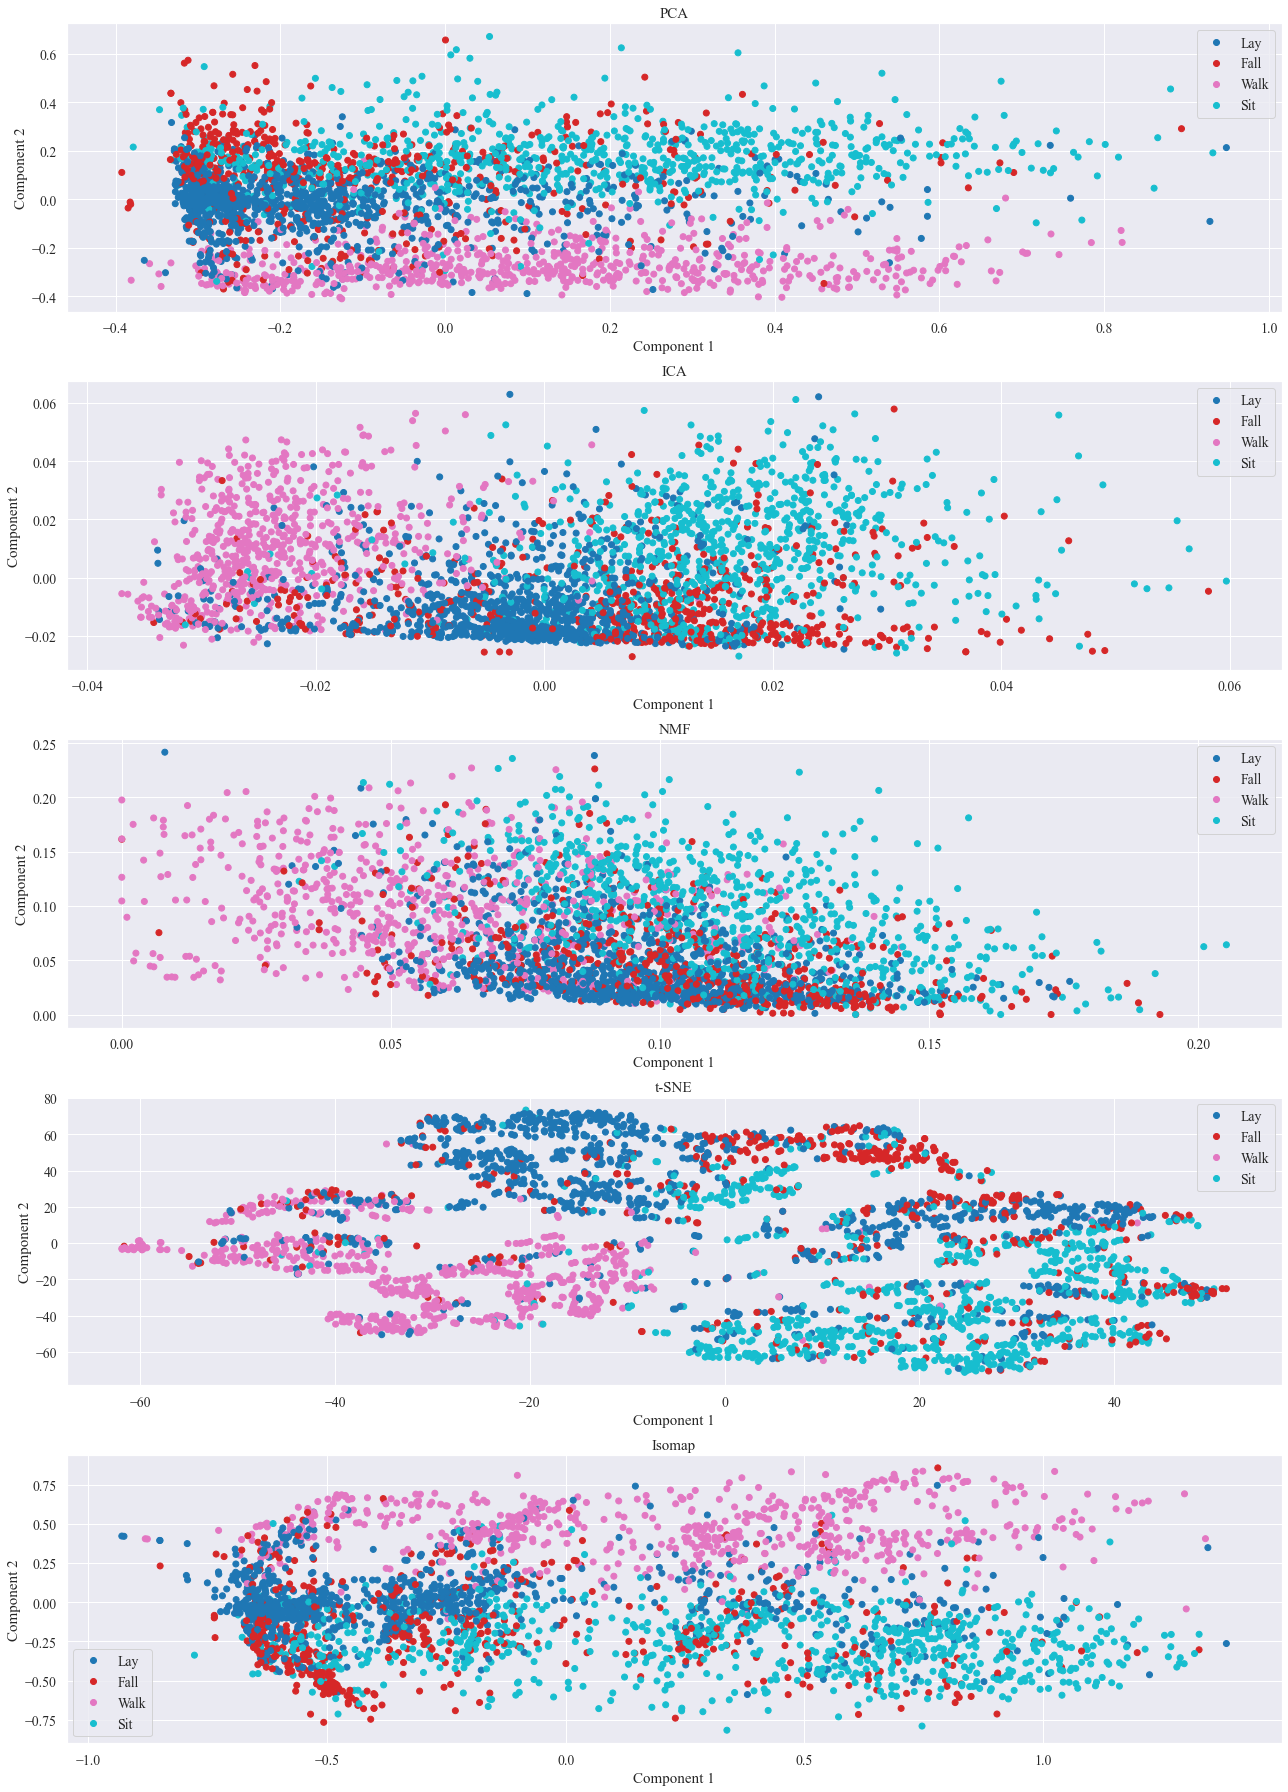

In [9]:
%matplotlib inline
from collections import OrderedDict
from sklearn.decomposition import PCA, FastICA, NMF
from sklearn.manifold import TSNE, Isomap

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    transforms = OrderedDict()
    transforms["PCA"] = PCA(n_components=2)
    transforms["ICA"] = FastICA(n_components=2)
    transforms["NMF"] = NMF(n_components=2, max_iter=1500)
    transforms["t-SNE"] = TSNE(n_components=2, perplexity=30)
    transforms["Isomap"] = Isomap(n_components=2)

    fig, axs = plt.subplots(nrows=len(transforms.keys()), ncols=1)
    fig.set_size_inches(18, 25)

    for ax, (title, transform) in zip(axs, transforms.items()):
        components = transform.fit_transform(df_picked_features)
        scatter = ax.scatter(components [:, 0], components [:, 1], c=Y, cmap="tab10")
        ax.set_title(title)
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        legend = ax.legend(*scatter.legend_elements())
        for label, text in zip(Consts.activity_legend, legend.get_texts()):
            text.set_text(label)

    fig.tight_layout()
    plt.show()

    del transform, transforms, title, ax, legend, label, text, scatter